# Climatology 


First stab at replicating: https://www.ncl.ucar.edu/Document/Functions/climo.shtml

In [1]:
import xarray as xr

In [2]:
ds = xr.tutorial.open_dataset('rasm').load()
ds

<xarray.Dataset>
Dimensions:  (time: 36, x: 275, y: 205)
Coordinates:
  * time     (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    xc       (y, x) float64 189.2 189.4 189.6 189.7 ... 17.65 17.4 17.15 16.91
    yc       (y, x) float64 16.53 16.78 17.02 17.27 ... 28.26 28.01 27.76 27.51
Dimensions without coordinates: x, y
Data variables:
    Tair     (time, y, x) float64 nan nan nan nan nan ... 29.8 28.66 28.19 28.21
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       "4.6.0"
    history:                   Tue Dec 27 14:15:22 2016: ncatted -a dimension...

In [3]:
def climatology(da, groupby_type='time.month'):
    gb = da.groupby(groupby_type)
    clim = gb.mean(dim='time')
    return clim, gb

def standard_deviation(da, groupby_type='time.month'):
    gb = da.groupby(groupby_type)
    std = gb.std(dim='time')
    return std

## Monthly Climatogy & Anomalies & Standard Deviations

/Users/abanihi/opt/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/Users/abanihi/opt/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


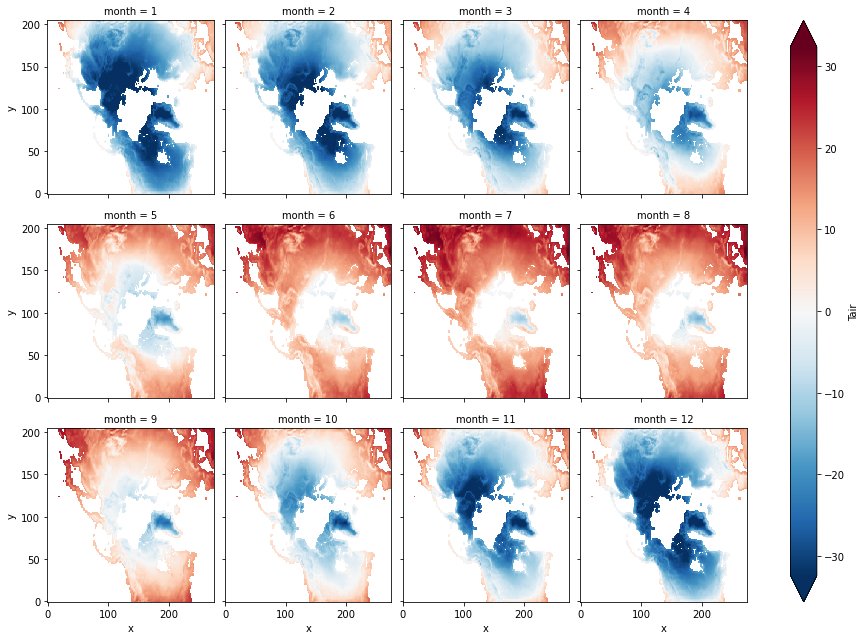

In [4]:
clim, gb = climatology(ds.Tair)
std = standard_deviation(ds.Tair)
clim.plot(col='month', robust=True, col_wrap=4);

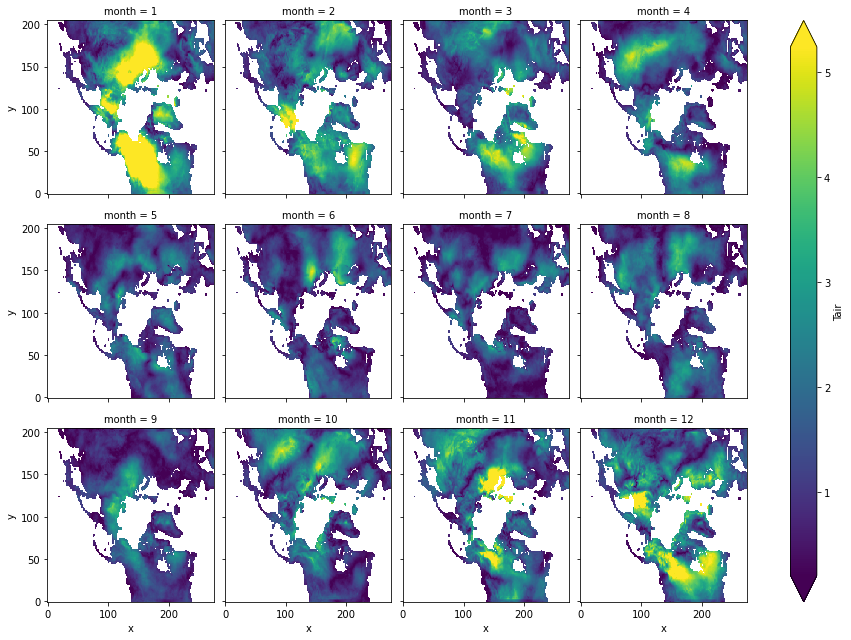

In [5]:
std.plot(col='month', robust=True, col_wrap=4);

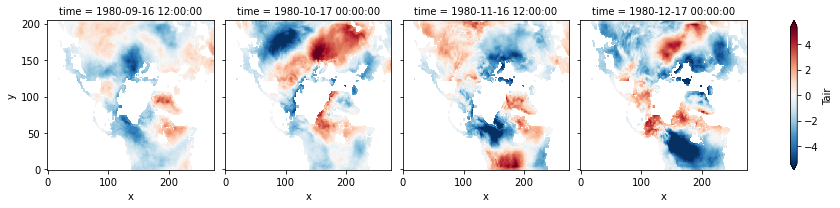

In [6]:
(clim - gb).isel(time=range(0, 4)).plot(col='time', robust=True);

## Yearly Climatogy & Anomalies & Standard Deviations

/Users/abanihi/opt/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/Users/abanihi/opt/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


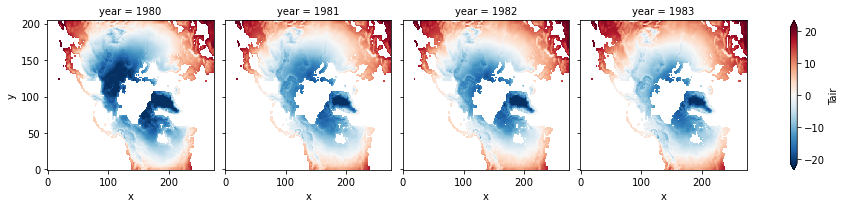

In [7]:
clim, gb = climatology(ds.Tair, groupby_type='time.year')
std = standard_deviation(ds.Tair, groupby_type='time.year')
clim.plot(col='year', robust=True);

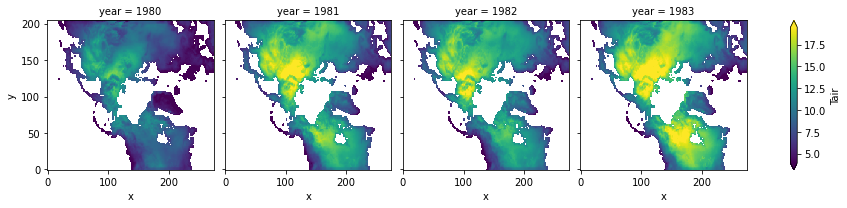

In [8]:
std.plot(col='year', robust=True);

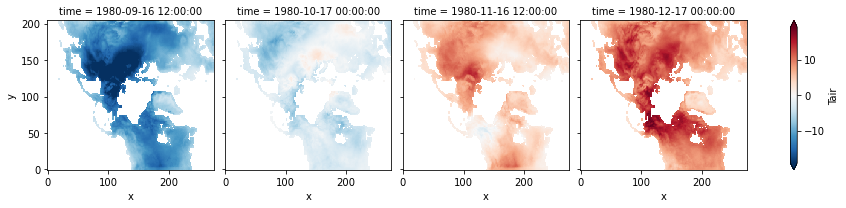

In [9]:
(clim - gb).isel(time=range(0, 4)).plot(col='time', robust=True);

## Seasonal Climatogy & Anomalies

/Users/abanihi/opt/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/Users/abanihi/opt/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


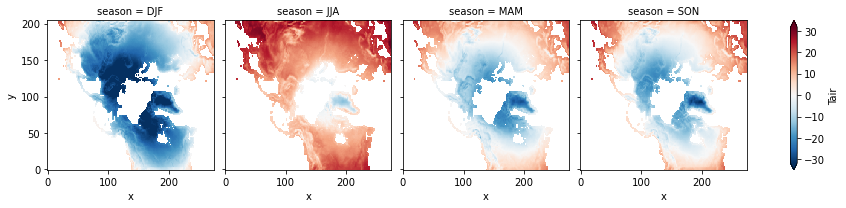

In [10]:
clim, gb = climatology(ds.Tair, groupby_type='time.season')
std = standard_deviation(ds.Tair, groupby_type='time.season')
clim.plot(col='season', robust=True);

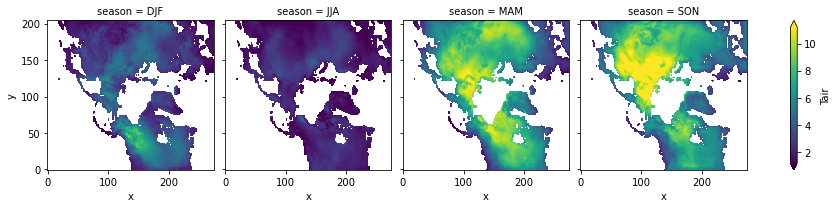

In [11]:
std.plot(col='season', robust=True);

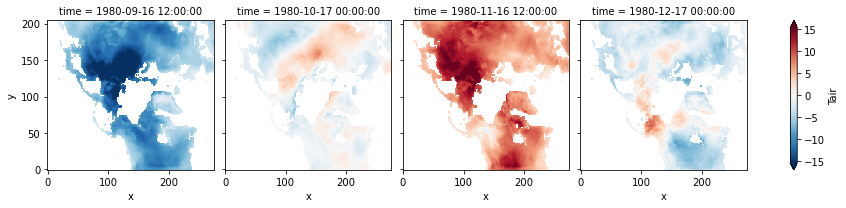

In [12]:
(clim - gb).isel(time=range(0, 4)).plot(col='time', robust=True);

## Month_to_season

In [13]:
# Copied from https://github.com/NCAR/GeoCAT-examples/pull/51
# Authored by Brian

def month_to_season(ds, season):
    """ This function takes an xarray dataset containing monthly data spanning years and
        returns a dataset with one sample per year, for a specified three-month season.
        Time stamps are centered on the season, e.g. seasons='DJF' returns January timestamps.
        If a calculated season's timestamp falls outside the original range of monthly values, then the calculated mean
        is dropped.  For example, if the monthly data's time range is [Jan-2000, Dec-2003] and the season is "DJF", the
        seasonal mean computed from the single month of Dec-2003 is dropped.
    """
    start = ds.time[0]
    end = ds.time[-1]
    seasons_pd = {'DJF': ('QS-DEC', 1), 'JFM': ('QS-JAN', 2), 'FMA': ('QS-FEB', 3), 'MAM': ('QS-MAR', 4),
                  'AMJ': ('QS-APR', 5), 'MJJ': ('QS-MAY', 6), 'JJA': ('QS-JUN', 7), 'JAS': ('QS-JUL', 8),
                  'ASO': ('QS-AUG', 9), 'SON': ('QS-SEP', 10), 'OND': ('QS-OCT', 11), 'NDJ': ('QS-NOV', 12)}
    try:
        (season_pd, season_sel) = seasons_pd[season]
    except KeyError:
        raise ValueError(f"contributed: month_to_season: bad season: SEASON = {season}")

    # Compute the three-month means, moving time labels ahead to the middle month.
    month_offset = 'MS'
    ds_seasons = ds.resample(time=season_pd, loffset=month_offset).mean()

    # Filter just the desired season, and trim to the desired time range.
    x = ds_seasons.sel(time=ds_seasons.time.dt.month == season_sel).sel(time=slice(start, end))
    return x

In [14]:
month_to_season(ds, "DJF")

/Users/abanihi/opt/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (time: 3, x: 275, y: 205)
Coordinates:
  * time     (time) object 1981-01-01 00:00:00 ... 1983-01-01 00:00:00
    xc       (y, x) float64 189.2 189.4 189.6 189.7 ... 17.65 17.4 17.15 16.91
    yc       (y, x) float64 16.53 16.78 17.02 17.27 ... 28.26 28.01 27.76 27.51
Dimensions without coordinates: x, y
Data variables:
    Tair     (time, y, x) float64 nan nan nan nan ... 13.74 12.43 12.26 12.47

In [15]:
month_to_season(ds, 'NDJ')

/Users/abanihi/opt/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (time: 3, x: 275, y: 205)
Coordinates:
  * time     (time) object 1980-12-01 00:00:00 ... 1982-12-01 00:00:00
    xc       (y, x) float64 189.2 189.4 189.6 189.7 ... 17.65 17.4 17.15 16.91
    yc       (y, x) float64 16.53 16.78 17.02 17.27 ... 28.26 28.01 27.76 27.51
Dimensions without coordinates: x, y
Data variables:
    Tair     (time, y, x) float64 nan nan nan nan nan ... 14.5 13.19 12.97 13.27